In [ ]:
# import modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from google.colab import files
from itertools import cycle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

In [ ]:
pip install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [ ]:
import catboost as cb

Three types of models were used: Random Forest Classifier, Logistic Regression classifier and CatBoost Classifier. Grid Searching was carried out to pick best parameters which were then applied to the ultimate models. The models were then compared.




Look at the dataset

In [ ]:
# upload the dataset
df=pd.read_csv('/content/sample_data/nysdoh_feature.csv')

In [ ]:
# look at first 5 rows
df.head()

,Unnamed: 0,Hospital_Service_Area,Hospital_County,Facility_Name,Age_Group,Zip_Code__3_digits,Gender,Race,Length_of_Stay,Type_of_Admission,CCS_Diagnosis_Description,CCS_Procedure_Description,Payment_Typology_1,Emergency_Department_Indicator,Below_Above_mean,length_groups,MeanLOS_byD,MeanLOS_byP
0,0,Western NY,Erie,Buffalo General Medical Center,40,142,F,W,3.0,Elective,Osteoarthritis,"HIP REPLACEMENT,TOT/PRT",MCR,N,below_mean,2-5,3.125348,3.901561
1,1,Western NY,Erie,Women And Children's Hospital Of Buffalo,20,OOS,F,AA,5.0,Urgent,Hypertension complicating pregnancy; childbirt...,CESAREAN SECTION,SP,N,below_mean,2-5,3.882438,3.798021
2,2,Western NY,Chautauqua,Brooks Memorial Hospital,10,140,M,W,3.0,Newborn,Liveborn,NO PROC,MCD,N,below_mean,2-5,3.599619,4.659893
3,3,Western NY,Cattaraugus,Olean General Hospital,40,147,F,W,6.0,Emergency,Complication of device; implant or graft,NO PROC,MCR,Y,above_mean,6-20,7.169666,4.659893
4,4,Western NY,Cattaraugus,Olean General Hospital,10,147,F,W,2.0,Newborn,Liveborn,PROPHYLACTIC VAC/INOCUL,BCBS,N,below_mean,2-5,3.599619,2.707005


In [ ]:
df.shape

(118049, 18)

# Run a Random Search to test different parameters for Random Forest 

In [ ]:
# Run a Random Grid Search CV on a fraction of the dataset to save computing time and improve efficiency
# Use roc_auc and f1_macro averaging for scoring, use two searches, to estimate best parameters, our main prediction of interest is 'above_mean' which is the minority group
# Hyperparameter tuning on Random Forest Classifier
# take those parameters and apply them to the df dataframe
# Time the model fit 

filepath='/content/sample_data/nysdoh_feature.csv'


In [ ]:
# take a sample of dfo for purposes of random search cv to get best params while improving efficiency by not doing grid search on the bigger df dataset
chunk_size=50000
df1=pd.DataFrame()
for chunk in pd.read_csv(filepath,chunksize=chunk_size,low_memory=False):
    df2=chunk.sample(frac=0.05)
    df=pd.concat([df1, df2])
    df1=df
# drop unwanted columns
df1=df1.drop(['Unnamed: 0','MeanLOS_byD', 'MeanLOS_byP'],axis=1)
#Determine columns for X
X=df1.drop(['Length_of_Stay',
        'Below_Above_mean', 'length_groups'
       ],axis=1)
# Due to categorical data, covert X column features to dummy variables to prepare for modelling
X=pd.get_dummies(X,drop_first=True)
# Target column is Below_Above_mean which has two classes. Map the classes and assign class of interest: above_mean to 1
Binary = {'above_mean': 1, 'below_mean': 0}
df1['Below_Above_mean'] = df1['Below_Above_mean'].map(Binary)
# conisder y variable as binary length groups
y=df1['Below_Above_mean']
# Complete a train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
# check dataset shape
df1.shape

(5902, 15)

In [ ]:
# Create a search grid
#Number of trees in random forest
n_estimators = [int(x) for x in range(100,350,50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [50,100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


# Using roc_auc scoring for Random Grid Search

In [ ]:
# check code time
time_start=time.perf_counter()
# Use the random grid to search for best hyperparameters
# Instantiate the Random Forest Classifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train, y_train)
time_end=time.perf_counter()
print((time_end-time_start)/60)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.8min finished


12.863404452366668


In [ ]:
#look at best parameters
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

# Applying the best params(scoring=roc_auc) to the random forest model 

In [ ]:
# load the dataset
df=pd.read_csv('/content/sample_data/nysdoh_feature.csv')
# remove unwanted columns
df=df.drop(['Unnamed: 0','MeanLOS_byD', 'MeanLOS_byP'],axis=1)


In [ ]:
df.shape

(118049, 15)

In [ ]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Length_of_Stay',
       'Type_of_Admission', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator', 'Below_Above_mean', 'length_groups'],
      dtype='object')

In [ ]:
# Target column is Below_Above_mean which has two classes. Map the classes and assign class of interest: above_mean to 1
Binary = {'above_mean': 1, 'below_mean': 0}

df['Below_Above_mean'] = df['Below_Above_mean'].map(Binary)
#assign target column to y
y=df['Below_Above_mean']
# assign X
X=df.drop(['Length_of_Stay',
        'Below_Above_mean', 'length_groups'
       ],axis=1)


In [ ]:
# assign dummy varaibales to categorical data
X=pd.get_dummies(X,drop_first=True)

In [ ]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [ ]:
# roc curve for RF model with optimal threshold

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = RandomForestClassifier(bootstrap= False,
 max_depth= 50,
 max_features='auto',
 min_samples_leaf=2,
 min_samples_split=10,
 n_estimators= 200)
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)


In [ ]:
# Best threshold based on f1 score for positive class
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
# Best threshold for f1 score: THRESHOLD
THRESHOLD=thresholds[ix]
#Calculate predcitions on best threshold
preds = np.where(model.predict_proba(testX)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(testy, preds), roc_auc_score(testy, preds)], index=["accuracy", "roc_auc_score"])



Threshold=0.314, F-Score=0.61841


,0
accuracy,0.760915
roc_auc_score,0.746971


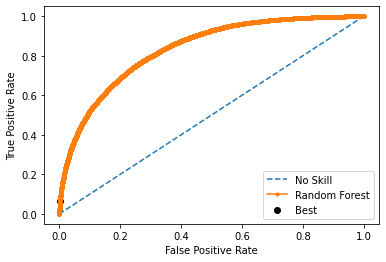

In [ ]:
#plot the ROC
from matplotlib import pyplot
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, probs)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#classification report at best threshold
print(classification_report(testy,preds))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83     43068
           1       0.54      0.72      0.62     15957

    accuracy                           0.76     59025
   macro avg       0.71      0.75      0.72     59025
weighted avg       0.79      0.76      0.77     59025



# Using f1_macro scoring for Random Grid Search

In [ ]:
# Using fraction of the df: dfo carry out a randomized search cV
# check code time
time_start=time.perf_counter()
# Use the random grid to search for best hyperparameters
# Instantiate the Random Forest Classifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='f1_macro')
# Fit the random search model
rf_random.fit(X_train, y_train)
time_end=time.perf_counter()
print((time_end-time_start)/60)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.2min finished


11.303505300516667


In [ ]:
#look at best parameters
rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

# Modeling Random Forest after picking best parameters (scoring=f1)

In [ ]:
# Apply best parameters from Random Search to Random Forest Classifier model on the entire dataset df

In [ ]:
# load the dataset
df=pd.read_csv('/content/sample_data/nysdoh_feature.csv')
# remove unwanted columns
df=df.drop(['Unnamed: 0','MeanLOS_byD', 'MeanLOS_byP'],axis=1)

In [ ]:
# Note dataset column names
df.columns

Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Length_of_Stay',
       'Type_of_Admission', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator', 'Below_Above_mean', 'length_groups'],
      dtype='object')

In [ ]:
#check dataset shape
df.shape

(118049, 15)

In [ ]:

# Target column is Below_Above_mean which has two classes. Map the classes and assign class of interest: above_mean to 1
Binary = {'above_mean': 1, 'below_mean': 0}

df['Below_Above_mean'] = df['Below_Above_mean'].map(Binary)
# assign X
X=df.drop(['Length_of_Stay',
        'Below_Above_mean', 'length_groups'
       ],axis=1)
# assign dummy varaibales to categorical data
X=pd.get_dummies(X,drop_first=True)
y=df['Below_Above_mean']
#split train test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)




In [ ]:
# time the code, fit the random forest classifier with best params
time_start=time.perf_counter()
model = RandomForestClassifier(bootstrap= False,
 max_depth= None,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 10,
 n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
time_end=time.perf_counter()
print((time_end-time_start)/60)

3.7908741336500005


In [ ]:
#predict probabilities
yhat=model.predict_proba(X_test)

In [ ]:
# Best threshold based on f1 score for positive class
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
# Best threshold for f1 score: THRESHOLD
THRESHOLD=thresholds[ix]
#Calculate predcitions on best threshold
preds = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

Threshold=0.283, F-Score=0.61731


,0
accuracy,0.756756
roc_auc_score,0.751752


In [ ]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82     17360
           1       0.53      0.74      0.62      6250

    accuracy                           0.76     23610
   macro avg       0.71      0.75      0.72     23610
weighted avg       0.80      0.76      0.77     23610



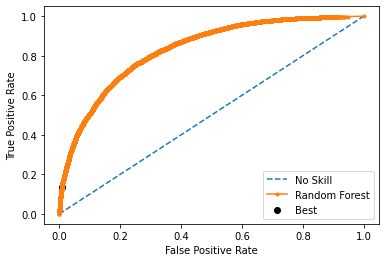

In [ ]:
#plot the ROC
from matplotlib import pyplot
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

30


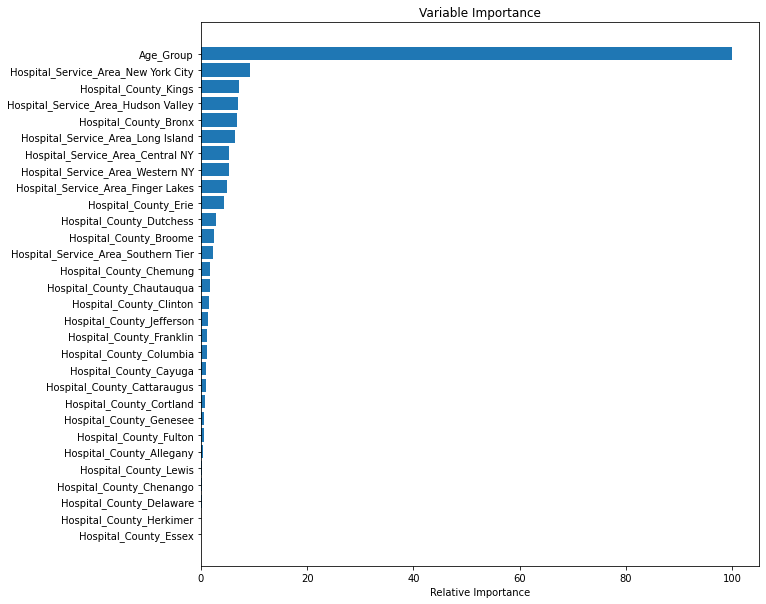

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Look at feature importance based on the random forest classifier
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('dfv1.png',bbox_inches='tight')
plt.show()
files.download('dfv1.png')

 Interestingly, the NY City hospital service area has the highest feature importance, followed by certain counties. 

# Look at features after removing geogrpaphical and location factors (hospital service area, county, facility name, and zip code).

In [ ]:
# Assign new X by removing location columns from X
X=df.drop(['Hospital_Service_Area', 'Hospital_County','Facility_Name',
       'Zip_Code__3_digits','Length_of_Stay',
        'Below_Above_mean', 'length_groups'],axis=1)
X=pd.get_dummies(X,drop_first=True)


In [ ]:
# create a train test split with new X, y is the same
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
# run the random forest classifier using best parameters, time the code
time_start=time.perf_counter()
model = RandomForestClassifier(bootstrap= False,
 max_depth= None,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 10,
 n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
time_end=time.perf_counter()

In [ ]:
# print time needed
print((time_end-time_start)/60)

2.28893908893333


In [ ]:
# Best threshold based on f1 score for positive class
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
# Best threshold for f1 score: THRESHOLD
THRESHOLD=thresholds[ix]
#Calculate predcitions on best threshold
preds = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

Threshold=0.283, F-Score=0.61731


,0
accuracy,0.738501
roc_auc_score,0.732529


In [ ]:
# Clasification report at best threshold
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81     17360
           1       0.50      0.72      0.59      6250

    accuracy                           0.74     23610
   macro avg       0.69      0.73      0.70     23610
weighted avg       0.78      0.74      0.75     23610



In [ ]:
# when comparing f1 scores of class 1 models that include location columns in X versus exclude the location in X , the AUC score, f1 scores and accuracy drop slightly

30


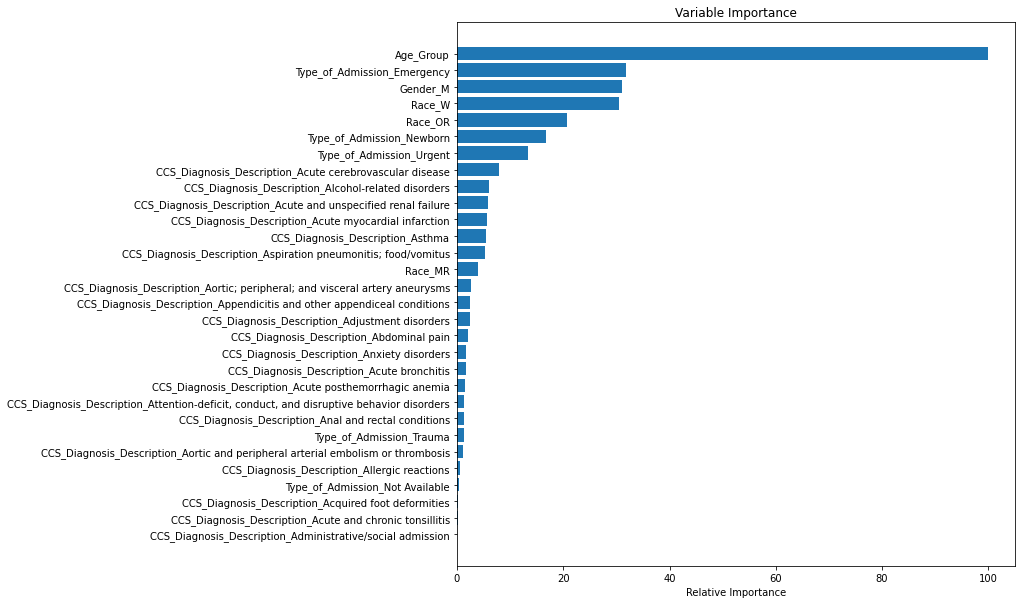

In [ ]:
# Look at feature importance based on the random forest classifier
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
#plt.savefig('dfv2.png')
plt.show()
#files.download('dfv2.png')

# Randomized Grid Search: find best parameters for Logistic Regression classifier, scoring on 'roc_auc' score

In [ ]:
filepath='/content/sample_data/nysdoh_feature.csv'
# take a sample of dfo for purposes of random search cv to get best params while improving efficiency by not doing on the bigger dfo dataset
chunk_size=50000
df1=pd.DataFrame()
for chunk in pd.read_csv(filepath,chunksize=chunk_size,low_memory=False):
    df2=chunk.sample(frac=0.05)
    df=pd.concat([df1, df2])
    df1=df
# drop unwanted columns
df1=df1.drop(['Unnamed: 0','MeanLOS_byD', 'MeanLOS_byP'],axis=1)
#Determine columns for X
X=df1.drop(['Length_of_Stay',
        'Below_Above_mean', 'length_groups'
       ],axis=1)
# Due to categorical data, covert X column features to dummy variables to prepare for modelling
X=pd.get_dummies(X,drop_first=True)
# Target column is Below_Above_mean which has two classes. Map the classes and assign class of interest: above_mean to 1
Binary = {'above_mean': 1, 'below_mean': 0}
df1['Below_Above_mean'] = df1['Below_Above_mean'].map(Binary)
# conisder y variable as binary length groups
y=df1['Below_Above_mean']
# Complete a train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
# create a grid for the random search
random_grid={"C":np.logspace(-3,3,7), "penalty":["l2"],"max_iter":(500,1000)}

In [ ]:
logreg=LogisticRegression()
logreg_rv=RandomizedSearchCV(logreg,random_grid,cv=3,scoring='roc_auc')
time_start=time.perf_counter()
logreg_rv.fit(X_train,y_train)
time_end=time.perf_counter()
print((time_end-time_start)/60)

In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_rv.best_params_)
print("accuracy :",logreg_rv.best_score_)

tuned hpyerparameters :(best parameters)  {'penalty': 'l2', 'max_iter': 500, 'C': 1.0}
accuracy : 0.8007010008228049


## Apply best parameters to Logistic Regression before feature selection

In [ ]:
df=pd.read_csv('/content/sample_data/nysdoh_feature.csv')
# remove unwanted columns
df=df.drop(['Unnamed: 0','MeanLOS_byD', 'MeanLOS_byP'],axis=1)
# Target column is Below_Above_mean which has two classes. Map the classes and assign class of interest: above_mean to 1
Binary = {'above_mean': 1, 'below_mean': 0}

df['Below_Above_mean'] = df['Below_Above_mean'].map(Binary)
# assign X
X=df.drop(['Length_of_Stay',
        'Below_Above_mean', 'length_groups'
       ],axis=1)
# assign dummy varaibales to categorical data
X=pd.get_dummies(X,drop_first=True)
y=df['Below_Above_mean']
#split train test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
# class 0: 17360,class 1: 6250
# class0/class 1 ratio = 2.8
print(17360/6250)

2.7776


In [ ]:
#inverse the weights for the classes and assign weights
w={0:1,1:2.8}

In [ ]:
#weighted Logistic Regression 
model = LogisticRegression(penalty='l2',C=1.0,max_iter=500,fit_intercept=False,class_weight=w)

In [ ]:
# execute fit
model.fit(X_train,y_train)


In [ ]:
# predict probabilities
yhat = model.predict_proba(X_test)

In [ ]:
# Best threshold based on f1 score for positive class
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))


Threshold=0.524, F-Score=0.61666


In [ ]:
# Best threshold for f1 score: THRESHOLD
THRESHOLD=thresholds[ix]
print(THRESHOLD)

0.524


In [ ]:
#Calculate predcitions on best threshold
preds = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

,0
accuracy,0.755612
roc_auc_score,0.751436


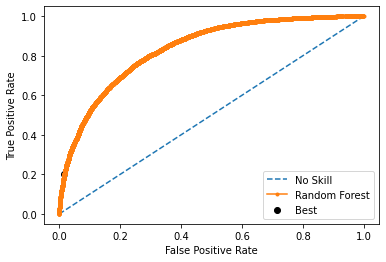

In [ ]:

#plot the ROC
from matplotlib import pyplot
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# classification report at best threshold
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82     17360
           1       0.53      0.74      0.62      6250

    accuracy                           0.76     23610
   macro avg       0.71      0.75      0.72     23610
weighted avg       0.79      0.76      0.77     23610



# Apply best parameters to Logistic Regression Classifier after feature selection

In [ ]:
# example of chi squared feature selection for categorical data
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot
 
 
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
#split train test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
# class 0: 17360,class 1: 6250
# class0/class 1 ratio = 2.8
#inversed the weights for the clases
w={0:1,1:2.8}
#weighted Logistic Regression 
model = LogisticRegression(penalty='l2',C=1.0,max_iter=500,fit_intercept=False,class_weight=w)
model.fit(X_train_fs, y_train)



In [ ]:
# predict probabilities
yhat = model.predict_proba(X_test_fs)
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.524, F-Score=0.61666


In [ ]:
# Best threshold for f1 score: THRESHOLD
THRESHOLD=thresholds[ix]
print(THRESHOLD)

0.524


In [ ]:
#Calculate predcitions on best threshold
preds = np.where(model.predict_proba(X_test_fs)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

,0
accuracy,0.755612
roc_auc_score,0.751436


In [ ]:
# classification report on best threshold using f1 score
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82     17360
           1       0.53      0.74      0.62      6250

    accuracy                           0.76     23610
   macro avg       0.71      0.75      0.72     23610
weighted avg       0.79      0.76      0.77     23610



 # Catboost Classifier
 1. Do a Random Grid Search on a fraction of the Dataframe dfo
 2. Apply best parameters fromt he Grid Search to the ultimate model

In [ ]:
filepath='/content/sample_data/nysdoh_feature.csv'
# take a sample of dfo for purposes of random search cv to get best params while improving efficiency by not doing on the bigger dfo dataset
chunk_size=50000
df1=pd.DataFrame()
for chunk in pd.read_csv(filepath,chunksize=chunk_size,low_memory=False):
    df2=chunk.sample(frac=0.05)
    df=pd.concat([df1, df2])
    df1=df
# drop unwanted columns
df1=df1.drop(['Unnamed: 0','MeanLOS_byD', 'MeanLOS_byP'],axis=1)
#Determine columns for X
X=df1.drop(['Length_of_Stay',
        'Below_Above_mean', 'length_groups'
       ],axis=1)
# For Cat Boost, X features have not been modified to dummy variables
#Convert Age_Group to Category
X['Age_Group']=X['Age_Group'].astype('category')
# Target column is Below_Above_mean which has two classes. Map the classes and assign class of interest: above_mean to 1
Binary = {'above_mean': 1, 'below_mean': 0}
df1['Below_Above_mean'] = df1['Below_Above_mean'].map(Binary)
# conisder y variable as binary length groups
y=df1['Below_Above_mean']


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# parameter for CatBoostClassifier()
categorical_features_indices = np.where(X.dtypes != np.float)[0]
cat_features=categorical_features_indices


In [ ]:
# Creat grid
random_grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [ ]:
# Complete the Randomized Grid Search
# check code time
time_start=time.perf_counter()
# Use the random grid to search for best hyperparameters
# Instantiate the model
model = CatBoostClassifier(loss_function='Logloss',cat_features=categorical_features_indices)
# Random search of parameters, using 3 fold cross validation, 

rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, cv = 3,random_state=42,scoring='roc_auc')
# Fit the random search model
rf_random.fit(X,y)
time_end=time.perf_counter()
print((time_end-time_start)/60)

In [ ]:
#look at best parameters
rf_random.best_params_

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.03}

In [ ]:
# apply to dataset df for the ultimate model
df=pd.read_csv('/content/sample_data/nysdoh_feature.csv')
# remove unwanted columns
df=df.drop(['Unnamed: 0','MeanLOS_byD', 'MeanLOS_byP'],axis=1)
# Target column is Below_Above_mean which has two classes. Map the classes and assign class of interest: above_mean to 1
Binary = {'above_mean': 1, 'below_mean': 0}

df['Below_Above_mean'] = df['Below_Above_mean'].map(Binary)
# assign X
X=df.drop(['Length_of_Stay',
        'Below_Above_mean', 'length_groups'
       ],axis=1)
y=df['Below_Above_mean']


In [ ]:
# For Cat Boost, X features have not been modified to dummy variables
#Convert Age_Group to Category
X['Age_Group']=X['Age_Group'].astype('category')

In [ ]:
#split train test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
#Instantiate CatBoostClassifier, use best parameters from the grid search
categorical_features_indices = np.where(X.dtypes != np.float)[0]
cat_features=categorical_features_indices
clf = CatBoostClassifier(loss_function='Logloss',cat_features=categorical_features_indices,depth= 4, l2_leaf_reg= 9, learning_rate= 0.03)
CatBoostClassifier()

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
yhat=clf.predict_proba(X_test)
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
#Best Threshold:THRESHOLD
THRESHOLD=thresholds[ix]
#Calculate predcitions on best threshold
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
#Classification report on best threshold using f1 scoring
print(classification_report(y_test,preds))

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

              precision    recall  f1-score   support

           0       0.89      0.80      0.84     17360
           1       0.56      0.71      0.63      6250

    accuracy                           0.78     23610
   macro avg       0.72      0.76      0.73     23610
weighted avg       0.80      0.78      0.78     23610



,0
accuracy,0.775985
roc_auc_score,0.756022


In [ ]:
print(THRESHOLD)

0.311


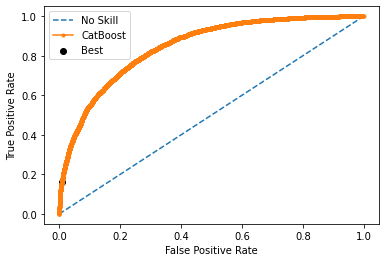

In [ ]:
#plot the ROC
from matplotlib import pyplot
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='CatBoost')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

After comparing th eultimate Random Forest Classifier, Logistic Regression classifier and CatBoost Classifier, the Catboost classifier performs better with a F1 score 0.63 for the above mean length of stay group, with ROC_AUC  of  0.76